In [1]:
# Copyright (c) Innoptech

# **OpenFDCM: Fast Template Matching for Object Pose Estimation**

### **Overview**
**OpenFDCM** (Fast Directional Chamfer Matching) is a high-performance, production-ready, fast template matching library designed to **enable object pose estimation**, particularly in industrial and manufacturing environments. This library excels at matching templates while remaining invariant to **translation** and **rotation** in the image plane.

The library is very extensible. One could easily implement a CUDA module for example.

This Jupyter notebook focuses solely on documenting the fast template matching algorithms provided by OpenFDCM. For complete 6-DOF pose estimation, please refer to the repository's [README.md](https://github.com/Innoptech/OpenFDCM/blob/main/README.md). It is important to note that the output of OpenFDCM generates a comprehensive list of match candidates, which should be refined using the multiview techniques discussed.

<a target="_blank" href="https://colab.research.google.com/drive/1AtXjSrxsd42BVli3xbOR2b8pRkfyrb0m?usp=sharing">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>


### Environment Set-up

* If running locally using jupyter, first install `openfdcm==0.8.1` in your environment using the installation instructions in the repository.

* If running from Google Colab, set using_colab=True below and run the cell.



In [2]:
using_colab = True

In [3]:
# Install required libraries
if using_colab:
  import sys
  !{sys.executable} -m pip install openfdcm==0.8.3
  !git clone --branch v0.8.3 --single-branch --depth 1 https://github.com/Innoptech/OpenFDCM



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.6/584.6 kB 9.4 MB/s eta 0:00:00
Cloning into 'OpenFDCM'...
remote: Enumerating objects: 675, done.
remote: Counting objects: 100% (675/675), done.
remote: Compressing objects: 100% (645/645), done.
remote: Total 675 (delta 27), reused 628 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (675/675), 5.16 MiB | 13.69 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Note: switching to 'e5c7088d88af15fe800bc0ec1b109ab831d67d18'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to fal

### Set-up

In [4]:
import time
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import openfdcm
print("OpenFDCM version:", openfdcm.__version__)

OpenFDCM version: 0.8.3


In [9]:
def apply_transform(template: np.ndarray, transform: np.ndarray):
    num_lines = template.shape[1]
    transformed_template = np.zeros_like(template)
    for i in range(num_lines):
        point1 = np.dot(transform[:2, :2], template[:2, i]) + transform[:2, 2]
        point2 = np.dot(transform[:2, :2], template[2:, i]) + transform[:2, 2]
        transformed_template[:2, i] = point1
        transformed_template[2:, i] = point2
    return transformed_template

def draw_lines(image: np.ndarray, lines: np.ndarray):
    for i in range(lines.shape[1]):
        pt1 = (int(lines[0, i]), int(lines[1, i]))
        pt2 = (int(lines[2, i]), int(lines[3, i]))
        cv2.line(image, pt1, pt2, (255, 0, 0), 1)
    return image

def display_best_match(scene_image: np.ndarray, best_matches: list[openfdcm.Match], templates: list[np.ndarray]):
    for match in best_matches:
        best_match_template = templates[match.tmpl_idx]
        transformed_template = apply_transform(best_match_template, match.transform)
        result_image = draw_lines(scene_image, transformed_template)
    result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(result_image_rgb)
    plt.axis('off')
    plt.show()

def find_files_recursive(directory, extension):
    return list(Path(directory).rglob(f"*{extension}"))

### Templates sampling
The template sampling consists in a fast OpenGL sythetic-rendered multiflash depth edge extraction. Further details can be seen in my master thesis (Ref to come).
<p float="left">
  <img src="https://raw.githubusercontent.com/Innoptech/OpenFDCM/v0.8.1/notebooks/images/templates_sampling.png" alt="Templates Sampling" width="45%" />
  <img src="https://raw.githubusercontent.com/Innoptech/OpenFDCM/v0.8.1/notebooks/images/multiflash_sampling.png" alt="Multiflash Sampling" width="45%" />
</p>

For the sake of simplification, the templates have already been generated in this example.

### Template matching
**Please note that Google Colab CPUs are quite slow.**  
**Also note that the shown matches should be refined using the multiview techniques discussed.**

In [6]:
from psutil import *
# This line will return the CPU info
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

Template matching search completed in 0.5120 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 9229.


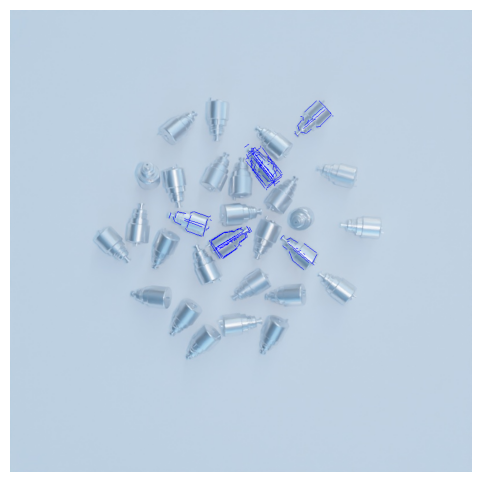

Template matching search completed in 0.5155 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 9098.


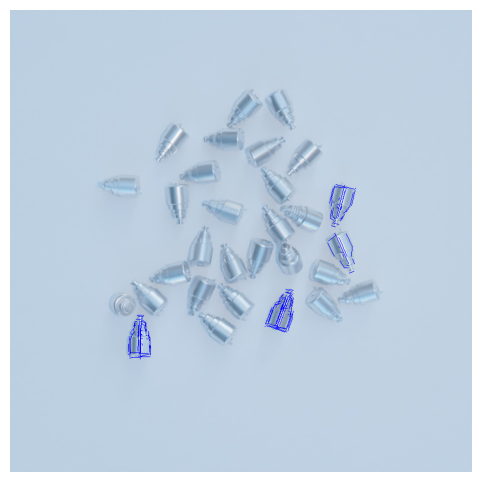

Template matching search completed in 0.5009 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8974.


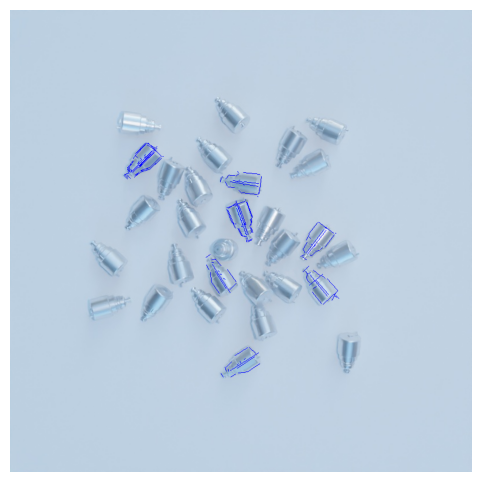

Template matching search completed in 0.6801 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 9079.


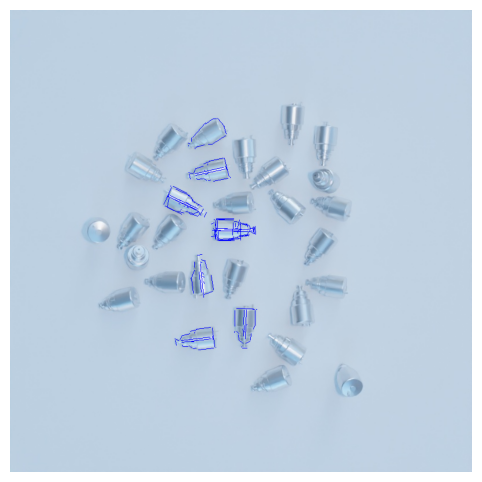

Template matching search completed in 0.5879 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8966.


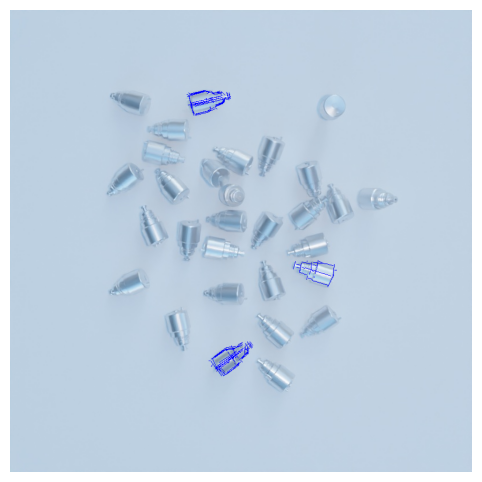

Template matching search completed in 0.5665 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 9298.


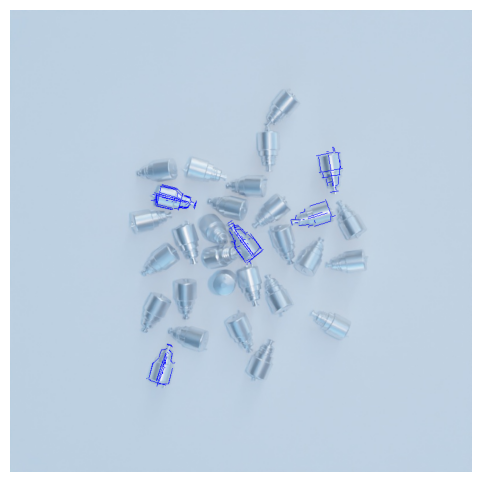

Template matching search completed in 0.5205 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8689.


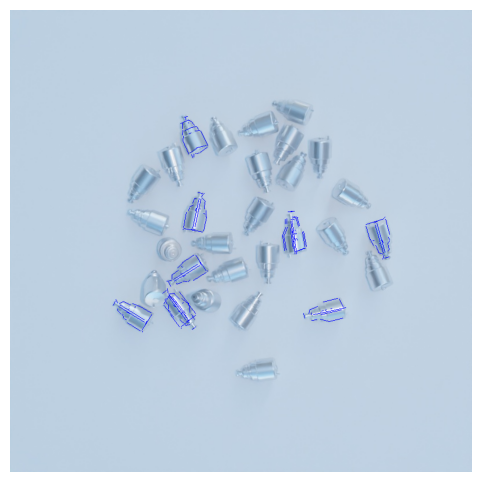

Template matching search completed in 0.5749 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 9256.


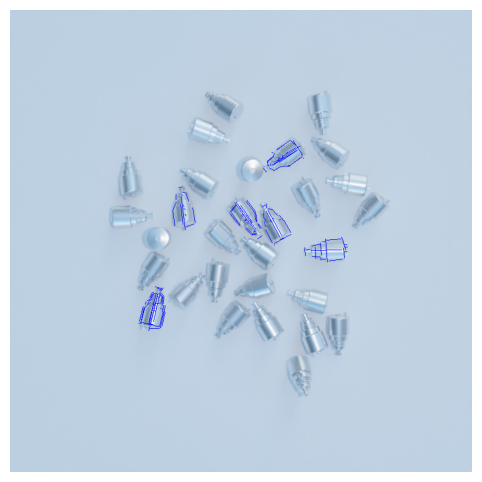

Template matching search completed in 0.5604 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 9130.


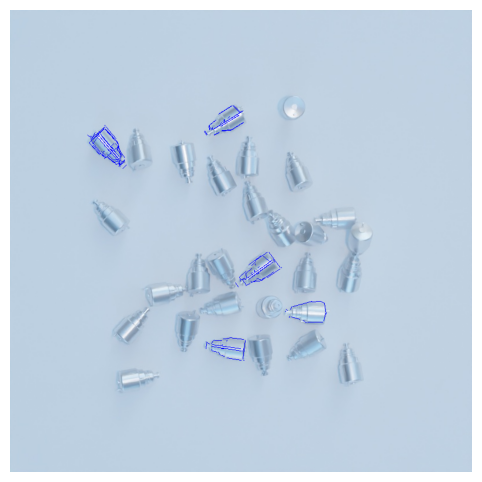

Template matching search completed in 0.5192 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8787.


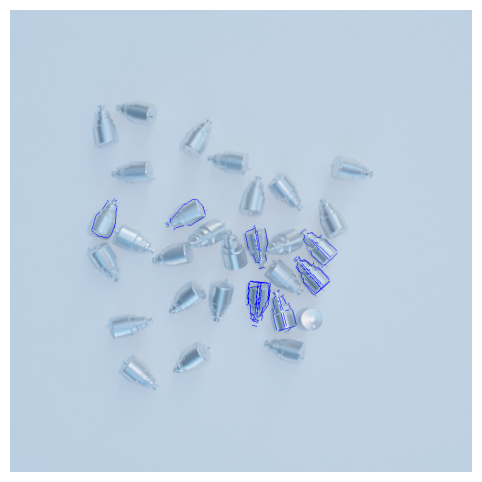

Template matching search completed in 0.6230 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6536.


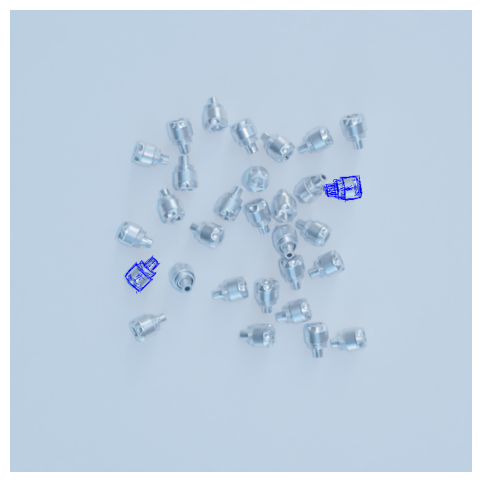

Template matching search completed in 0.8226 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6555.


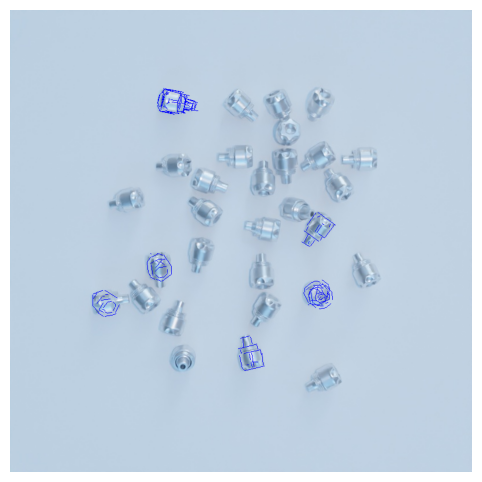

Template matching search completed in 0.7587 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6738.


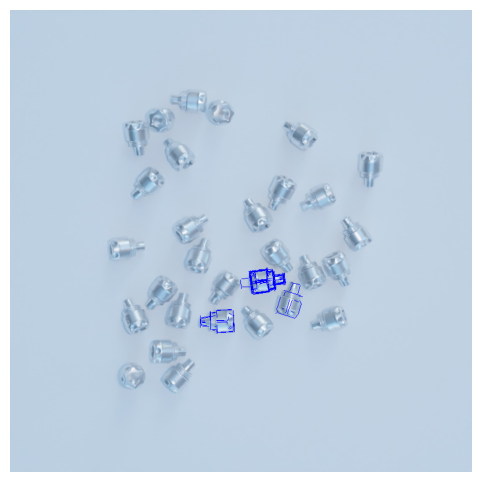

Template matching search completed in 0.5638 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6718.


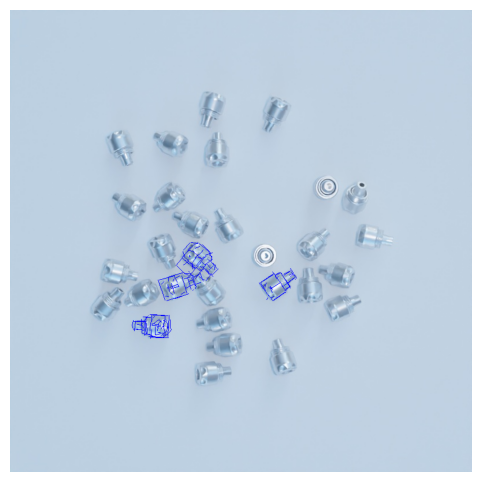

Template matching search completed in 0.5072 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6768.


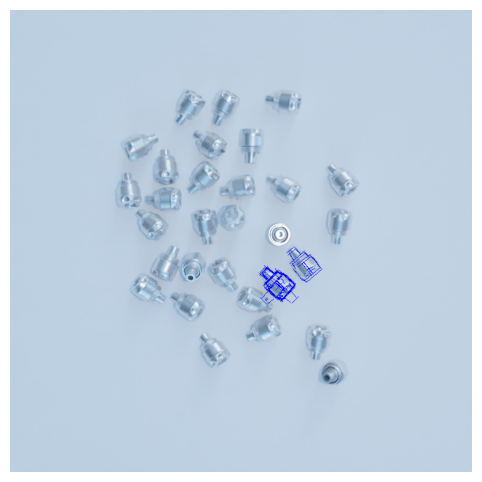

Template matching search completed in 0.5358 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6719.


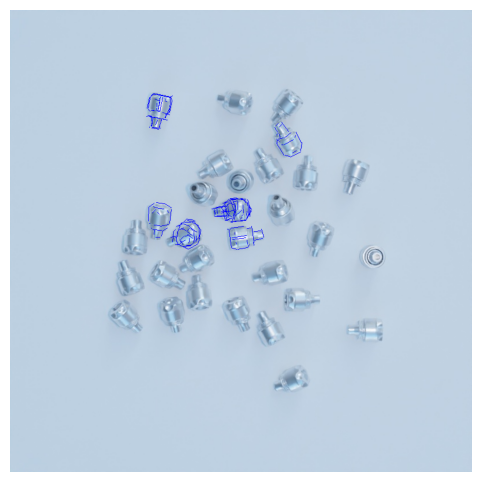

Template matching search completed in 0.4900 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7076.


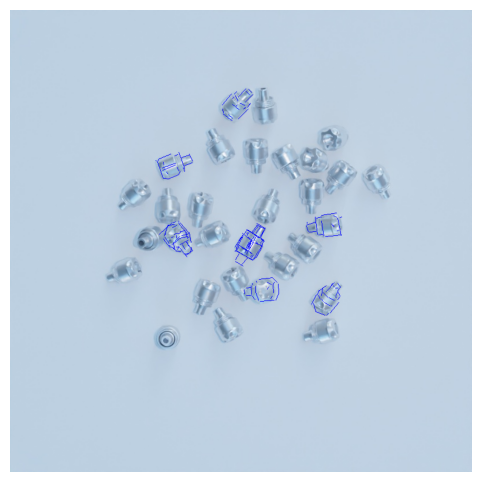

Template matching search completed in 0.5613 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7043.


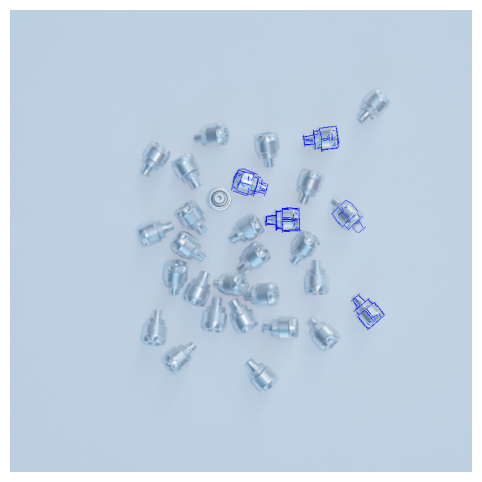

Template matching search completed in 0.5058 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6932.


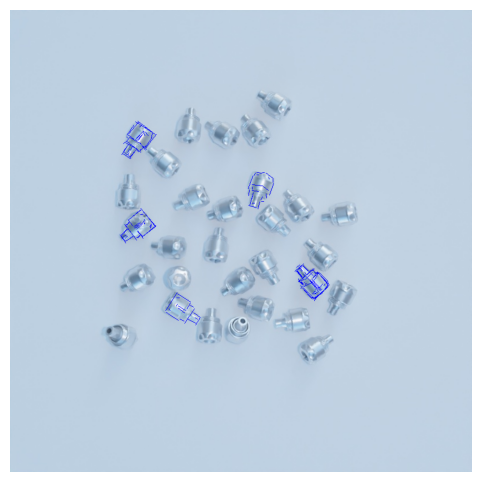

Template matching search completed in 0.4899 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6767.


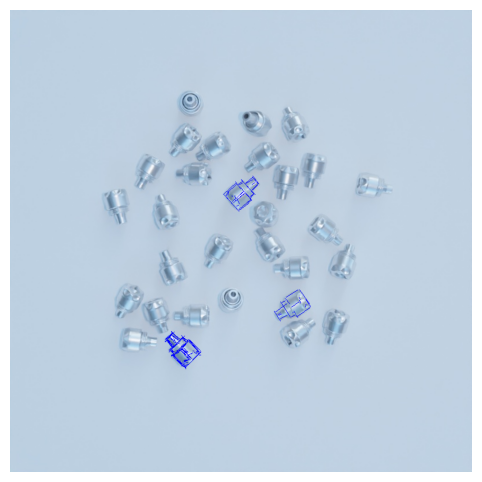

Template matching search completed in 0.4999 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6653.


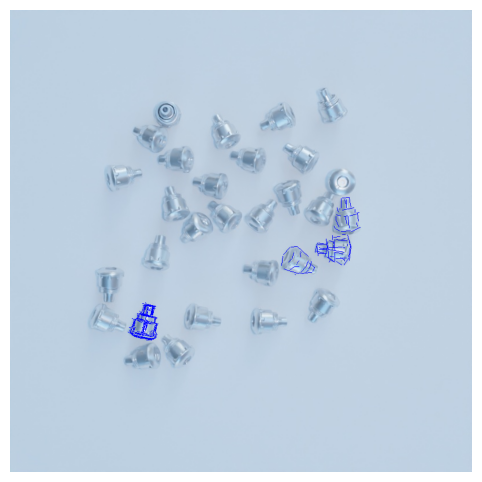

Template matching search completed in 0.5560 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6710.


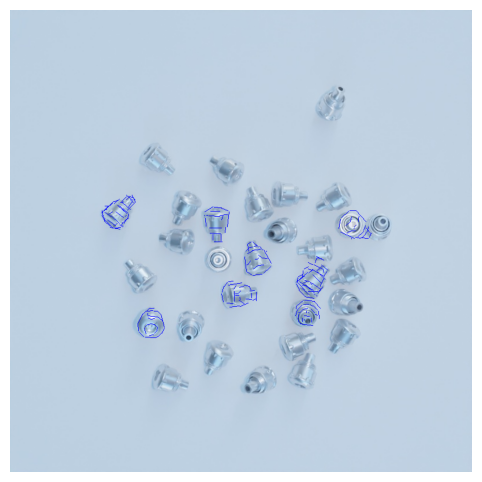

Template matching search completed in 0.8468 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7025.


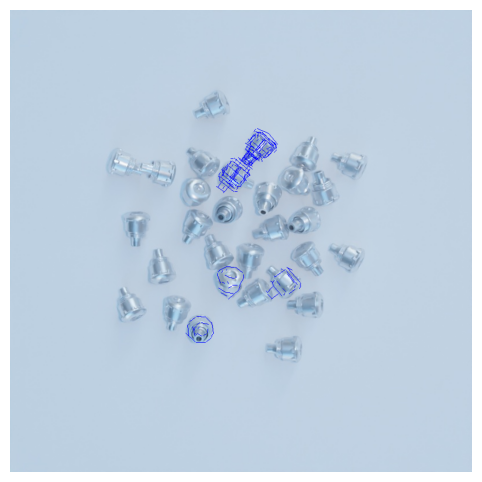

Template matching search completed in 0.5610 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6805.


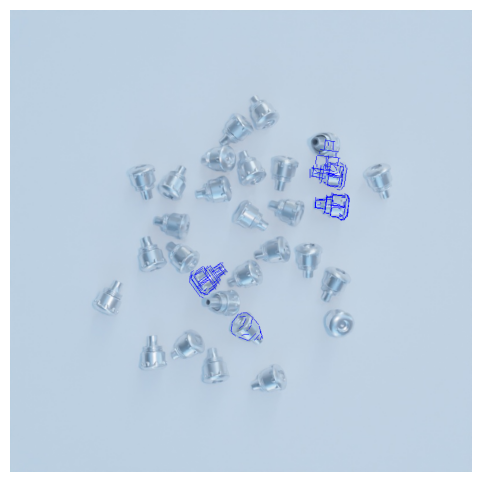

Template matching search completed in 0.5697 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7082.


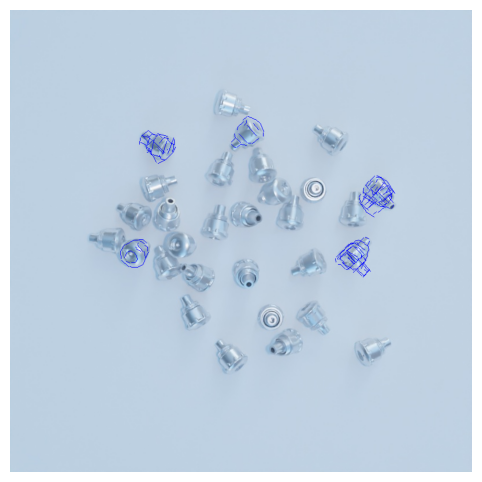

Template matching search completed in 0.6184 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7215.


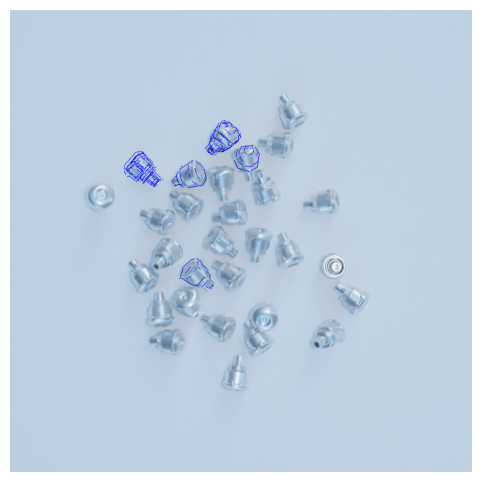

Template matching search completed in 0.9370 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 6835.


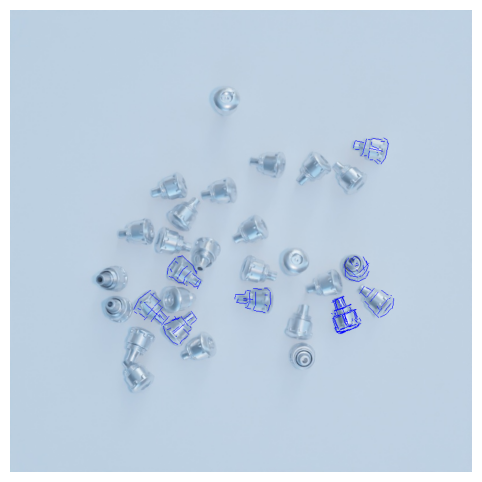

Template matching search completed in 0.8876 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7150.


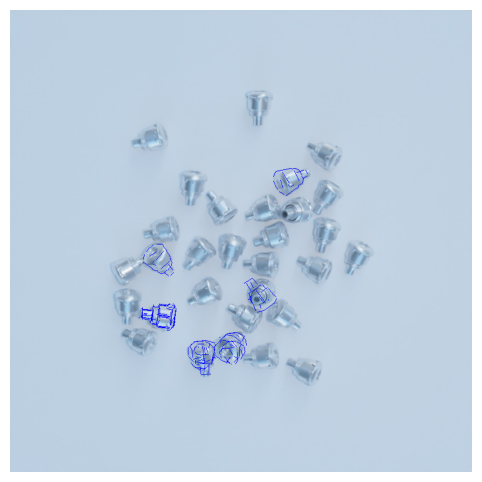

Template matching search completed in 0.6774 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7130.


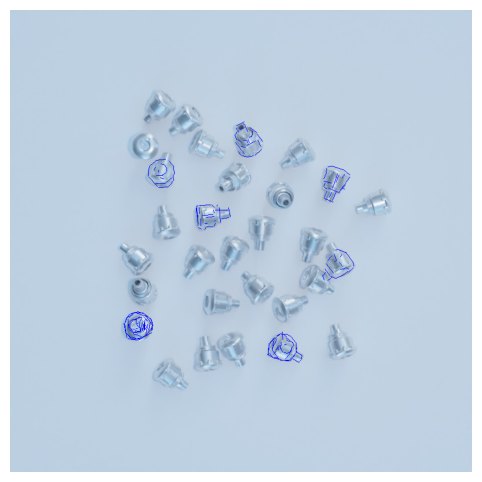

Template matching search completed in 0.5439 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 7089.


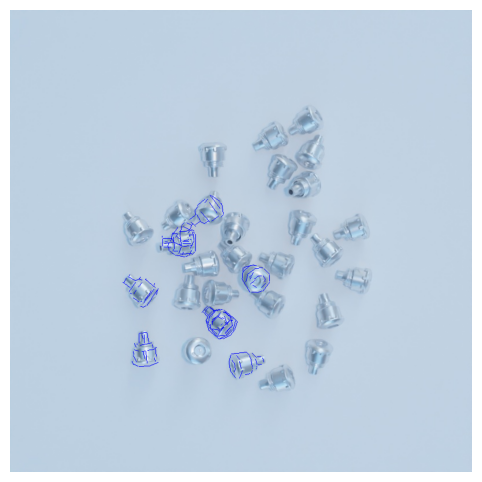

Template matching search completed in 0.4569 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8592.


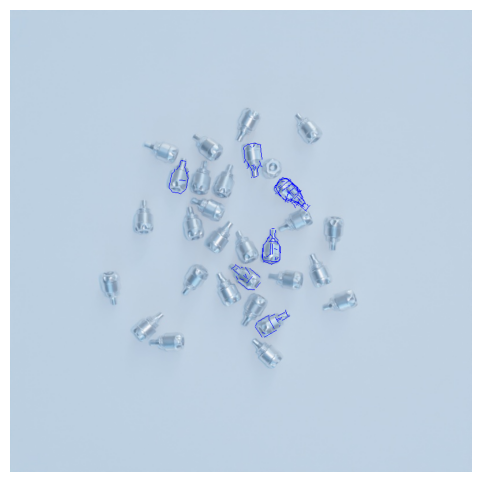

Template matching search completed in 0.8424 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8519.


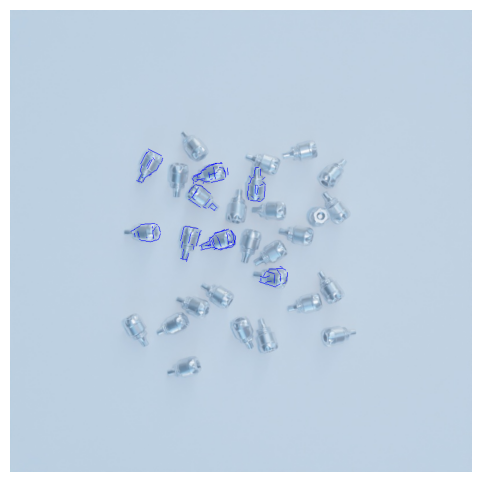

Template matching search completed in 0.8558 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8206.


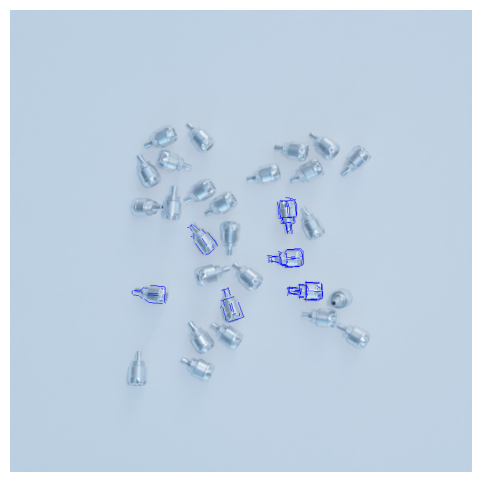

Template matching search completed in 0.5193 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8495.


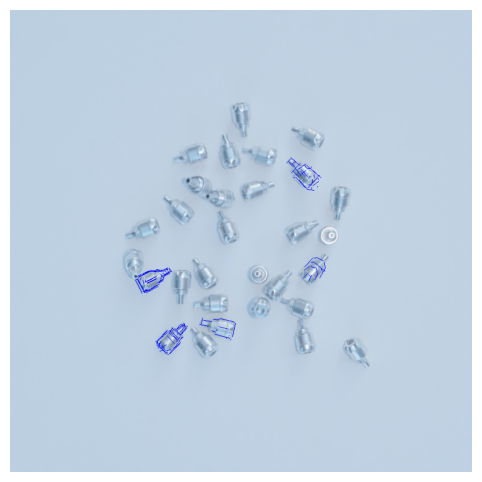

Template matching search completed in 0.5131 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8791.


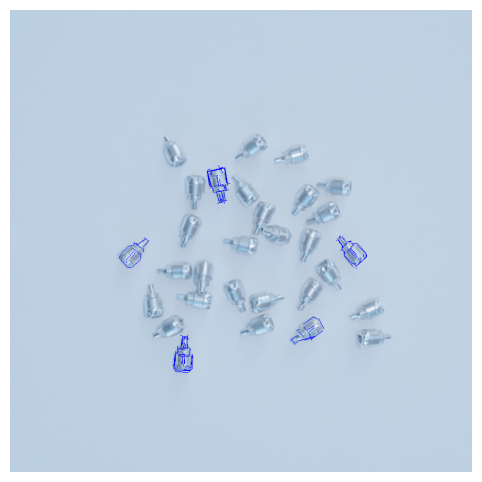

Template matching search completed in 0.4970 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8634.


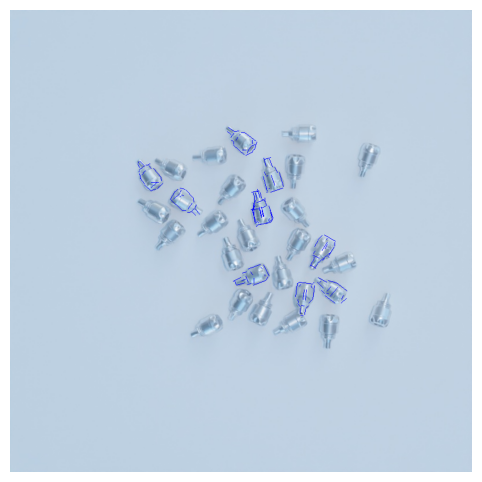

Template matching search completed in 0.5491 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8598.


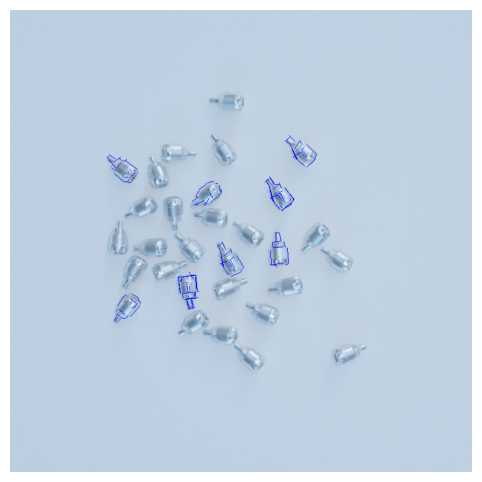

Template matching search completed in 0.6111 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8941.


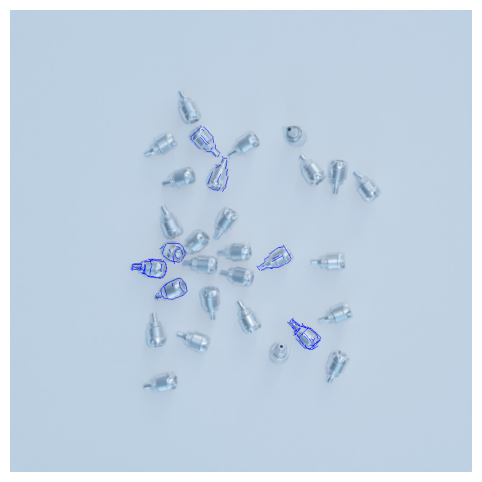

Template matching search completed in 0.5383 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8133.


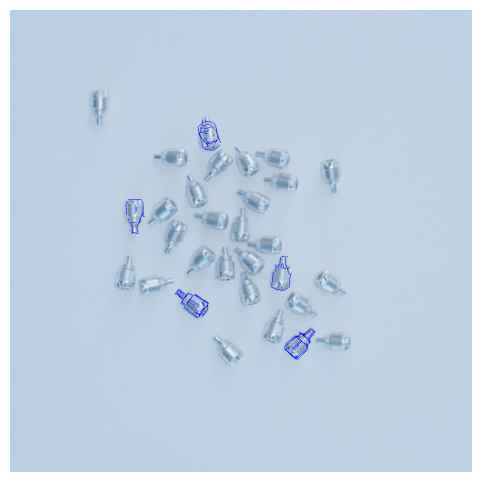

Template matching search completed in 0.4936 seconds (see image above for unrefined 10 best matches).
Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.
Number of unfiltered match candidates: 8577.


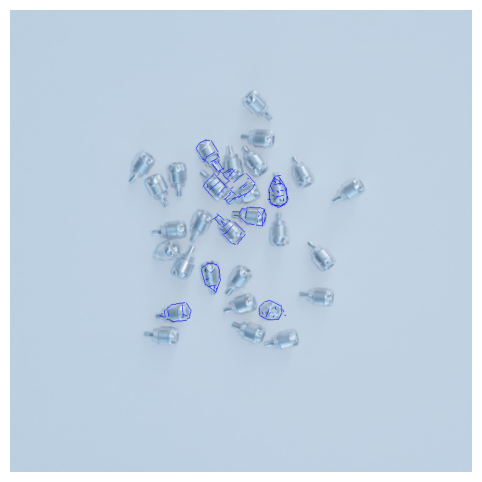

In [10]:
for imagepth in find_files_recursive("./OpenFDCM/examples/assets", ".jpg"):
    scene_dir: Path = imagepth.parent
    obj_dir: Path = scene_dir.parent
    templates_dir: Path = scene_dir.parent / "templates"

    scene_image = cv2.imread(str(imagepth))
    scene = openfdcm.read(str(scene_dir/"camera_0.scene"))

    templates = []
    for tmpl_path in find_files_recursive(templates_dir, ".tmpl"):
        templates.append(openfdcm.read(str(tmpl_path)))

    # Perform template matching
    max_tmpl_lines, max_scene_lines = 4, 10  # Combinatory search parameters (the higer the better but exp slower).
    depth = 30              # The [0, pi] discretization, the higher, the most precise but lin slower.
    scene_padding = 1.0     # A ratio to pad the scene images used in the FDCM algorithm, use if best match may appear on image boundaries.
    coeff = 5.0             # A weighting factor to enhance the angular cost vs distance cost in FDCM algorithm.
    #num_threads = 4

    threadpool = openfdcm.ThreadPool() # could pass num_threads here, but default is optimal
    featuremap_params = openfdcm.Dt3CpuParameters(depth, coeff, scene_padding)
    search_strategy = openfdcm.DefaultSearch(max_tmpl_lines, max_scene_lines)
    optimizer_strategy = openfdcm.BatchOptimize(10, threadpool)
    matcher = openfdcm.DefaultMatch()
    penalizer = openfdcm.ExponentialPenalty(tau=1.5)

    # Build FDCm feature map and search
    start_time = time.time()
    featuremap = openfdcm.build_cpu_featuremap(scene, featuremap_params, threadpool)
    raw_matches = openfdcm.search(matcher, search_strategy, optimizer_strategy, featuremap, templates, scene)
    penalized_matches = openfdcm.penalize(penalizer, raw_matches, openfdcm.get_template_lengths(templates))
    sorted_matches = openfdcm.sort_matches(penalized_matches)
    search_time = time.time() - start_time
    print(f"Template matching search completed in {search_time:.4f} seconds (see image above for unrefined 10 best matches).")
    print("Expected performance: Should run at 22 FPS (0.045ms) on an i7-14700 CPU with max_tmpl_lines = 4, max_scene_lines = 10, depth = 30.")
    print(f"Number of unfiltered match candidates: {len(sorted_matches)}.")

    if sorted_matches:
        best_matches = sorted_matches[:10]
        display_best_match(scene_image, best_matches, templates)